# membrane heater


## Imports, define model

In [1]:
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size']=16
import numpy as np
import h5py
from matplotlib.colors import LogNorm

path = os.getcwd()
basepath = os.path.dirname(path)
datapath = basepath+'/data'
figpath = basepath+'/figures'
srcpath =  basepath +'/src'

if srcpath not in sys.path:
    sys.path.append(srcpath)

import models
from pdeSim import PoissonFlow2D    

v_max = 0.05

k_in,c_in,rho_in,Q_in,v_in,x,y,dx,dy,nx,ny = models.single_wire_membrane(v=v_max,wet=True)

freq=0

save_file = True

save_name = 'membrane_heater' 

x = np.linspace(-(nx-1)/2*dx,(nx-1)/2*dx,nx)*1e6
y = np.linspace(-(ny-1)/2*dy,(ny-1)/2*dy,ny)*1e6

## Plot heat sources/sinks

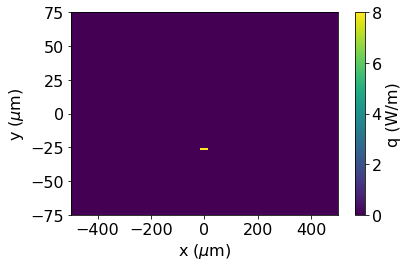

In [2]:
fig,ax=plt.subplots(1,1,figsize=[6,4])

myplot = ax.pcolor(x,y,Q_in.T,shading='auto')
ax.set_xlim(x.min(),x.max())
ax.set_ylim(y.min(),y.max())
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
cbar = fig.colorbar(myplot)
cbar.set_label('q (W/m)')
fig.tight_layout()

if save_file==True:
    fig.savefig(figpath+ '/'+save_name+'_q.png',facecolor='w',dpi=300)

## Plot thermal conductivities

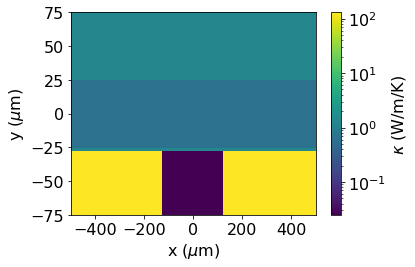

In [3]:


fig,ax=plt.subplots(1,1,figsize=[6,4])
myplot = ax.pcolor(x[::1],y[::1],k_in.T[::1,::1],shading='auto',norm=LogNorm(vmin=k_in.min(),vmax=k_in.max()))
ax.set_xlim(x.min(),x.max())
ax.set_ylim(y.min(),y.max())
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
cbar = fig.colorbar(myplot)
cbar.set_label('$\kappa$ (W/m/K)')


fig.tight_layout()
if save_file==True:
    fig.savefig(figpath+'/'+save_name+'_kappa.png',facecolor='w',dpi=300)

## Solve

In [4]:
pf = PoissonFlow2D(Q_in,k_in,v_in,dx,dy,c_in,rho_in,freq)
%time out = pf.sparseSolve()

CPU times: user 2.49 s, sys: 97.5 ms, total: 2.59 s
Wall time: 1.4 s


## Plot results

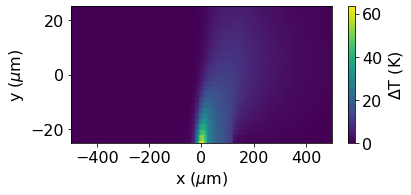

In [5]:
fig,ax=plt.subplots(1,1,figsize=[6,3])

myplot = ax.pcolor(x[::2],y[::2],out.real.T[::2,::2],shading='auto')
#ax.set_xlim(x.min(),x.max())
ax.set_xlim(x.min(),x.max())
ax.set_ylim(-25,25)

ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
cbar = fig.colorbar(myplot)
cbar.set_label('$\Delta$T (K)')
fig.tight_layout()
if save_file==True:
    fig.savefig(figpath+'/'+save_name+'_T.png',facecolor='w',dpi=300)

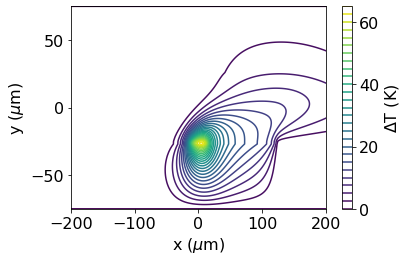

In [6]:
fig,ax=plt.subplots(1,1,figsize=[6,4])
u,v = np.gradient(out.real.T)

myplot = ax.contour(x[:],y[:],out.real.T,30)

ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
ax.set_xlim([-200,200])
fig.tight_layout()
ax.set_xticks([-200,-100,0,100,200])
ax.set_yticks([-50,0,50])
cbar=fig.colorbar(myplot)
cbar.set_label('$\Delta$T (K)')
cbar.set_ticks([0,20,40,60,80])
if save_file==True:
    fig.savefig(figpath+'/'+save_name+'_T_cont.png',facecolor='w',dpi=300)

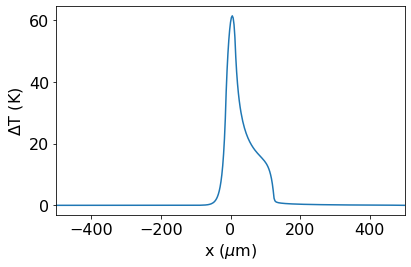

In [7]:
fig,ax=plt.subplots(1,1,figsize=[6,4])

myplot = ax.plot(x,out.real.T[50,:])
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('$\Delta$T (K)')
ax.set_xlim(x.min(),x.max())
fig.tight_layout()
if save_file==True:
    fig.savefig(figpath+'/'+save_name+'_Tx.png',facecolor='w',dpi=300)

## Figure out thermal resistance

In [8]:
Q_tot = np.sum(Q_in)*1e-4
#print(Q_tot)

T_av=np.average(out.real.T[53:54,175:225])
print('Thermal resistance',T_av/Q_tot/1e3,'K/mW')

Thermal resistance 2.4813745910499336 K/mW


## Save, if needed

In [9]:
if save_file==True:
    f=h5py.File(datapath+'/'+save_name+'.hdf5','w')

    f.attrs['dx']= dx
    f.attrs['dy']= dy
    f.attrs['nx']= nx
    f.attrs['notes']= np.string_('no flow case')
    
    dset_v = f.create_dataset("v", (ny,), dtype='f')
    dset_v[...]=v_in[0,:]

    dset_T = f.create_dataset("T", (nx,ny), dtype='f')
    dset_T[...]=out.real

    dset_kappa = f.create_dataset("kappa", (nx,ny), dtype='f')
    dset_kappa[...]=k_in
    
    dset_Q_in = f.create_dataset("Q_in", (nx,ny), dtype='f')
    dset_Q_in[...]=Q_in

    dset_c_in = f.create_dataset("c", (nx,ny), dtype='f')
    dset_c_in[...]=c_in
    
    dset_rho_in = f.create_dataset("rho", (nx,ny), dtype='f')
    dset_rho_in[...]=rho_in

    f.close()